<a href="https://colab.research.google.com/github/KhudV/MML/blob/main/Lab5_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения



##### Студент:  Худицкий Василий
##### Группа:   НКНбд-01-19

## Москва 2022
***

### Вариант №13

1. Считайте котировки акции с указанным ниже тикером за 2019-2020 год:

 C         Citigroup Inc

2. Показатель акции: дневной убыток/, способ визуализации – эмпирическая CDF  

3. Прогнозирование стоимости акции через 10 дней по данным за предыдущие 40 дней.

4. Показатель качества MSE

5. Техника борьбы с исчезающими градиентами:

Альтернативная инициализация весов

Решение:

1. При помощи модуля `pandas_datareader` считайте котировки указанной в индивидуальным задании акции за указанный период времени.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

yfin.pdr_override()

In [ ]:
c = pdr.get_data_yahoo('C',
                          start=dt.datetime(2019, 1, 1),
                          end=dt.datetime(2020, 12, 31))
c.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,50.680000,53.740002,50.669998,53.529999,47.678234,21646300
2019-01-03,53.410000,53.619999,52.220001,52.560001,46.814281,21183000
2019-01-04,54.009998,55.380001,53.660000,55.130001,49.103336,24205100
2019-01-07,55.330002,56.209999,54.799999,55.610001,49.530865,20634100
2019-01-08,56.029999,56.189999,54.759998,55.459999,49.397259,18840100


In [ ]:
c.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,60.000000,61.310001,59.790001,60.779999,57.921440,16579100
2020-12-24,60.930000,61.090000,59.880001,60.570000,57.721313,6824400
2020-12-28,60.619999,61.930000,60.490002,61.130001,58.254978,14414600
2020-12-29,61.150002,61.400002,60.549999,60.910000,58.045322,10800400
2020-12-30,60.910000,61.270000,60.669998,60.860001,57.997681,10770700


2. Визуализируйте котировки акции (столбец `Adj Close`) за весь период на графике. Подпишите оси и рисунок.

Text(0, 0.5, 'Стоимость')

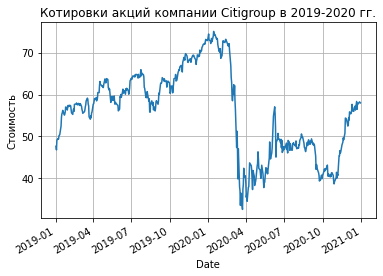

In [ ]:
c['Adj Close'].plot.line(grid=True,title='Котировки акций компании Citigroup в 2019-2020 гг.');
plt.ylabel('Стоимость')

3. Вычислите и визуализируйте заданный показатель акции в соответствии с индивидуальным заданием.

In [ ]:
d_close = c[['Adj Close']]
d_close

,Adj Close
Date,
2019-01-02,47.678234
2019-01-03,46.814281
2019-01-04,49.103336
2019-01-07,49.530865
2019-01-08,49.397259
...,...
2020-12-23,57.921440
2020-12-24,57.721313
2020-12-28,58.254978


In [ ]:
d_pct_ch2 = d_close.shift(1)-d_close
d_pct_ch2

,Adj Close
Date,
2019-01-02,NaN
2019-01-03,0.863953
2019-01-04,-2.289055
2019-01-07,-0.427528
2019-01-08,0.133606
...,...
2020-12-23,-1.448513
2020-12-24,0.200127
2020-12-28,-0.533665


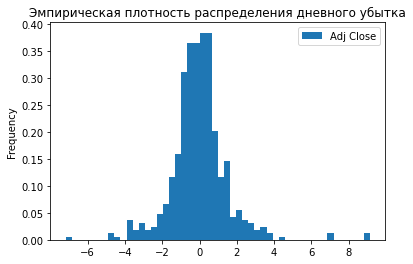

In [ ]:
d_pct_ch2.plot.hist(bins=50, title='Эмпирическая плотность распределения дневного убытка', density=True);

4. Сформируйте обучающую, тестовую и валидационные выборки для обучения нейронной сети в соответствии с индивидуальным заданием.

In [ ]:
num_train_samples = int(0.5 * len(c))
num_val_samples = int(0.25 * len(c))
num_test_samples = len(c) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 252
num_val_samples: 126
num_test_samples: 126


In [ ]:
ds_train, ds_test, ds_val = np.array(c[['Adj Close']][:num_train_samples]).reshape(-1), np.array(c[['Adj Close']][num_train_samples:num_test_samples+num_train_samples]).reshape(-1), np.array(c[['Adj Close']][-num_val_samples:]).reshape(-1)

In [ ]:
ds_train.shape, ds_test.shape, ds_val.shape

((252,), (126,), (126,))

In [ ]:
def create_ds(ds, look_back=1, forward=10):
  dataX, dataY = [], []
  for i in range(len(ds)-look_back-forward-1):
    a = ds[i:(i+look_back)]
    dataX.append(a)
    dataY.append(ds[i + look_back + forward])
  return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 40
trainX, trainY = create_ds(ds_train, look_back=look_back)
testX, testY = create_ds(ds_test, look_back=look_back)
valX, valY = create_ds(ds_val, look_back=look_back)
trainX.shape, trainY.shape, testX.shape, testY.shape, valX.shape, valY.shape

((201, 40), (201,), (75, 40), (75,), (75, 40), (75,))

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
valX = np.reshape(valX, (testX.shape[0], 1, valX.shape[1]))
trainX.shape, testX.shape, valX.shape

((201, 1, 40), (75, 1, 40), (75, 1, 40))

5. Постройте нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

In [ ]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(1, 40))
feature_normalizer.adapt(trainX)

In [ ]:
model_mlp = tf.keras.Sequential([
  feature_normalizer,
  tf.keras.layers.Dense(16, input_shape=(1,look_back), activation='tanh', name='HiddenLayer'),
  tf.keras.layers.Dense(1, name='OutputLayer')])
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1, 40)            3         
 n)                                                              
                                                                 
 HiddenLayer (Dense)         (None, 1, 16)             656       
                                                                 
 OutputLayer (Dense)         (None, 1, 1)              17        
                                                                 
Total params: 676
Trainable params: 673
Non-trainable params: 3
_________________________________________________________________


In [ ]:
model_mlp.compile(loss='mean_squared_error', optimizer='adam')
history = model_mlp.fit(trainX, trainY, epochs=100, batch_size=128, validation_data=(valX, valY), verbose=2)

Epoch 1/100
2/2 - 1s - loss: 3968.3918 - val_loss: 2210.6416 - 923ms/epoch - 461ms/step
Epoch 2/100
2/2 - 0s - loss: 3963.7046 - val_loss: 2208.9382 - 35ms/epoch - 17ms/step
Epoch 3/100
2/2 - 0s - loss: 3958.9856 - val_loss: 2207.1150 - 34ms/epoch - 17ms/step
Epoch 4/100
2/2 - 0s - loss: 3954.3054 - val_loss: 2204.9006 - 42ms/epoch - 21ms/step
Epoch 5/100
2/2 - 0s - loss: 3949.4521 - val_loss: 2202.3359 - 28ms/epoch - 14ms/step
Epoch 6/100
2/2 - 0s - loss: 3944.8589 - val_loss: 2198.9458 - 33ms/epoch - 16ms/step
Epoch 7/100
2/2 - 0s - loss: 3940.1829 - val_loss: 2195.1982 - 42ms/epoch - 21ms/step
Epoch 8/100
2/2 - 0s - loss: 3935.8955 - val_loss: 2190.9849 - 29ms/epoch - 14ms/step
Epoch 9/100
2/2 - 0s - loss: 3931.1140 - val_loss: 2186.3147 - 33ms/epoch - 16ms/step
Epoch 10/100
2/2 - 0s - loss: 3926.7878 - val_loss: 2181.7024 - 34ms/epoch - 17ms/step
Epoch 11/100
2/2 - 0s - loss: 3922.4067 - val_loss: 2175.8271 - 80ms/epoch - 40ms/step
Epoch 12/100
2/2 - 0s - loss: 3917.8015 - val_loss

In [ ]:
testPredict = model_mlp.predict(testX)

In [ ]:
def my_mse(y_test, y_predict):
    return np.sum((y_predict - y_test)**2) / len(y_test)

In [ ]:
testScore = my_mse(testY, testPredict.reshape(-1))
print('Test Score: %.2f MSE' % (testScore))

Test Score: 1931.32 MSE


6. Примените указанную в индивидуальном задании технику решения проблемы исчезающих градиентов и постройте нейронную сеть MLP с нормализующим слоем и тремя плотными скрытыми слоями из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества для тестовой выборки.

In [ ]:
import keras

In [ ]:
model_mlp2 = tf.keras.Sequential([
  feature_normalizer,
  tf.keras.layers.Dense(16, input_shape=(1,look_back), activation='tanh', kernel_initializer=keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')),
  tf.keras.layers.Dense(16, input_shape=(1,look_back), activation='tanh', kernel_initializer=keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')),
  tf.keras.layers.Dense(16, input_shape=(1,look_back), activation='tanh', kernel_initializer=keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')),
  tf.keras.layers.Dense(1, name='OutputLayer')])
model_mlp2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1, 40)            3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1, 16)             656       
                                                                 
 dense_1 (Dense)             (None, 1, 16)             272       
                                                                 
 dense_2 (Dense)             (None, 1, 16)             272       
                                                                 
 OutputLayer (Dense)         (None, 1, 1)              17        
                                                                 
Total params: 1,220
Trainable params: 1,217
Non-trainable params: 3
____________________________________________________

In [ ]:
model_mlp2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model_mlp2.fit(trainX, trainY, epochs=100, batch_size=128, validation_data=(valX, valY), verbose=2)

Epoch 1/100
2/2 - 1s - loss: 3992.3174 - val_loss: 2196.0454 - 1s/epoch - 740ms/step
Epoch 2/100
2/2 - 0s - loss: 3979.0957 - val_loss: 2184.1594 - 68ms/epoch - 34ms/step
Epoch 3/100
2/2 - 0s - loss: 3966.1377 - val_loss: 2176.3098 - 55ms/epoch - 28ms/step
Epoch 4/100
2/2 - 0s - loss: 3954.2500 - val_loss: 2168.0964 - 45ms/epoch - 22ms/step
Epoch 5/100
2/2 - 0s - loss: 3943.2095 - val_loss: 2161.8708 - 47ms/epoch - 24ms/step
Epoch 6/100
2/2 - 0s - loss: 3931.6670 - val_loss: 2156.4019 - 55ms/epoch - 28ms/step
Epoch 7/100
2/2 - 0s - loss: 3921.2693 - val_loss: 2151.0083 - 58ms/epoch - 29ms/step
Epoch 8/100
2/2 - 0s - loss: 3910.5293 - val_loss: 2146.6726 - 50ms/epoch - 25ms/step
Epoch 9/100
2/2 - 0s - loss: 3900.8792 - val_loss: 2143.2178 - 53ms/epoch - 26ms/step
Epoch 10/100
2/2 - 0s - loss: 3891.5559 - val_loss: 2140.0696 - 44ms/epoch - 22ms/step
Epoch 11/100
2/2 - 0s - loss: 3882.1179 - val_loss: 2139.7195 - 44ms/epoch - 22ms/step
Epoch 12/100
2/2 - 0s - loss: 3872.9976 - val_loss: 2

In [ ]:
testPredict2 = model_mlp2.predict(testX)

In [ ]:
testScore = my_mse(testY, testPredict2.reshape(-1))
print('Test Score: %.2f MSE' % (testScore))

Test Score: 1643.03 MSE


7. Постройте рекуррентную нейронную сеть с нормализующим слоем и одним скрытым слоем LSTM из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

In [ ]:
model_rnn = tf.keras.Sequential([
  feature_normalizer,
  tf.keras.layers.LSTM(16, input_shape=(1,look_back)),
  tf.keras.layers.Dense(1, name='OutputLayer')])
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1, 40)            3         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 16)                3648      
                                                                 
 OutputLayer (Dense)         (None, 1)                 17        
                                                                 
Total params: 3,668
Trainable params: 3,665
Non-trainable params: 3
_________________________________________________________________


In [ ]:
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
history3 = model_rnn.fit(trainX, trainY, epochs=100, batch_size=128, validation_data=(valX, valY), verbose=2)

Epoch 1/100
2/2 - 3s - loss: 3946.3657 - val_loss: 2227.6926 - 3s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 3941.5354 - val_loss: 2215.8652 - 30ms/epoch - 15ms/step
Epoch 3/100
2/2 - 0s - loss: 3936.4192 - val_loss: 2204.5872 - 30ms/epoch - 15ms/step
Epoch 4/100
2/2 - 0s - loss: 3931.9304 - val_loss: 2193.3125 - 32ms/epoch - 16ms/step
Epoch 5/100
2/2 - 0s - loss: 3927.1985 - val_loss: 2182.9006 - 30ms/epoch - 15ms/step
Epoch 6/100
2/2 - 0s - loss: 3922.7351 - val_loss: 2173.3284 - 30ms/epoch - 15ms/step
Epoch 7/100
2/2 - 0s - loss: 3918.2202 - val_loss: 2164.8921 - 30ms/epoch - 15ms/step
Epoch 8/100
2/2 - 0s - loss: 3913.7561 - val_loss: 2157.7561 - 36ms/epoch - 18ms/step
Epoch 9/100
2/2 - 0s - loss: 3909.2979 - val_loss: 2150.8247 - 31ms/epoch - 16ms/step
Epoch 10/100
2/2 - 0s - loss: 3904.8284 - val_loss: 2144.6899 - 37ms/epoch - 19ms/step
Epoch 11/100
2/2 - 0s - loss: 3900.2207 - val_loss: 2138.8765 - 42ms/epoch - 21ms/step
Epoch 12/100
2/2 - 0s - loss: 3895.6633 - val_loss: 2133

In [ ]:
testPredict3 = model_rnn.predict(testX)

In [ ]:
testScore = my_mse(testY, testPredict3.reshape(-1))
print('Test Score: %.2f MSE' % (testScore))

Test Score: 1617.43 MSE


8. Визуализируйте кривые обучения для трех построенных моделей на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительную ошибку (ошибку обучения, деленную на начальную ошибку на первой эпохе).

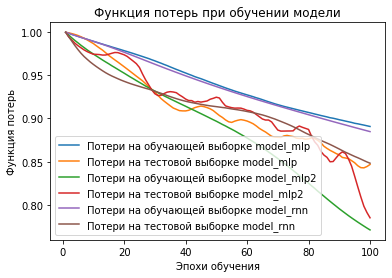

In [ ]:
loss1 = np.array(history.history["loss"])/history.history["loss"][0]
val_loss1 = np.array(history.history["val_loss"])/history.history["val_loss"][0]
loss2 = np.array(history2.history["loss"])/history2.history["loss"][0]
val_loss2 = np.array(history2.history["val_loss"])/history2.history["val_loss"][0]
loss3 = np.array(history3.history["loss"])/history3.history["loss"][0]
val_loss3 = np.array(history3.history["val_loss"])/history3.history["val_loss"][0]
epochs = range(1, len(loss1) + 1)
plt.plot(epochs, loss1, label="Потери на обучающей выборке model_mlp")
plt.plot(epochs, val_loss1, label="Потери на тестовой выборке model_mlp")
plt.plot(epochs, loss2, label="Потери на обучающей выборке model_mlp2")
plt.plot(epochs, val_loss2, label="Потери на тестовой выборке model_mlp2")
plt.plot(epochs, loss3, label="Потери на обучающей выборке model_rnn")
plt.plot(epochs, val_loss3, label="Потери на тестовой выборке model_rnn")
plt.title("Функция потерь при обучении модели")
plt.xlabel("Эпохи обучения")
plt.ylabel("Функция потерь")
plt.legend();

9. Визуализируйте весь набор данных и прогнозы трех построенных моделей для обучающей и тестовой выборок на одном рисунке (ось X – даты, ось Y – стоимость акции), подписывая оси и рисунок и создавая легенду.

In [ ]:
trainPredict = model_mlp.predict(trainX)
trainPredict2 = model_mlp2.predict(trainX)
trainPredict3 = model_rnn.predict(trainX)

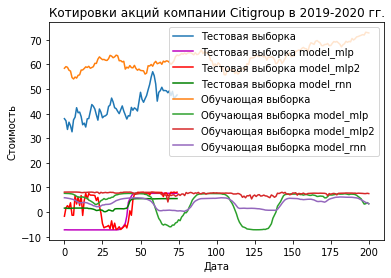

In [ ]:
plt.title('Котировки акций компании Citigroup в 2019-2020 гг.')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.plot(testY, label='Тестовая выборка')
plt.plot(testPredict.reshape(-1), c='m', label='Тестовая выборка model_mlp')
plt.plot(testPredict2.reshape(-1), c='r', label='Тестовая выборка model_mlp2')
plt.plot(testPredict3.reshape(-1), c='g', label='Тестовая выборка model_rnn')
plt.plot(trainY, label='Обучающая выборка')
plt.plot(trainPredict.reshape(-1), label='Обучающая выборка model_mlp')
plt.plot(trainPredict2.reshape(-1), label='Обучающая выборка model_mlp2')
plt.plot(trainPredict3.reshape(-1), label='Обучающая выборка model_rnn')
plt.legend();